# A Neural Network for Regression (Estimate blood pressure from PPG signal)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

Having gained some experience with neural networks, let us train a network that estimates the blood pressure from a PPG signal window.

All of your work for this exercise will be done in this notebook.

# A Photoplethysmograph (PPG) signal

A PPG (photoplethysmograph) signal is a signal obtained with a pulse oximeter, which illuminates the skin and measures changes in light absorption. A PPG signal carries rich information about the status of the cardiovascular health of a person, such as breadth rate, heart rate and blood pressure. An example is shown below, where you also see the blood pressure signal that we will estimate (the data also has the ECG signal, which you should ignore).

<img width="80%" src="PPG_ABG_ECG_example.png">


# Constructing the Dataset 

In this task, you are expected to perform the full pipeline for creating a learning system from scratch. Here is how you should construct the dataset:
* Download the dataset from the following website, and only take "Part 1" from it (it is too big): https://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation
* Take a window of size $W$ from the PPG channel between time $t$ and $t+W$. Let us call this $\textbf{x}_t$.
* Take the corresponding window of size $W$ from the ABP (arterial blood pressure) channel between time $t$ and $t+W$. Find the maxima and minima of this signal within the window (you can use "findpeaks" from Matlab or "find_peaks_cwt" from scipy). Here is an example window from the ABP signal, and its peaks:
 <img width="60%" src="ABP_peaks.png">
    
* Calculate the average of the maxima, call it $y^1_t$, and the average of the minima, call it $y^2_t$.
* Slide the window over the PPG signals and collect many $(\textbf{x}_t, <y^1_t, y^2_t>)$ instances. In other words, your network outputs two values.
* This will be your input-output for training the network.

In [1]:
import random
import numpy as np
from metu.data_utils import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/ertugrulcan46/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.
from cs231n.classifiers.neural_net_for_regression import TwoLayerNet

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4], [2, 1, 4], [2, 1, 4]])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net_for_regression.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the previous exercises: It takes the data and weights and computes the *regression* scores, the squared error loss, and the gradients on the parameters. 

To be more specific, you will implement the following loss function:

$$\frac{1}{2}\sum_i\sum_{j} (o_{ij} - y_{ij})^2 + \frac{1}{2}\lambda\sum_j w_j^2,$$

where $i$ runs through the samples in the batch; $o_{ij}$ is the prediction of the network for the $i^{th}$ sample for output $j$, and $y_{ij}$ is the correct value; $\lambda$ is the weight of the regularization term.

The first layer uses ReLU as the activation function. The output layer does not use any activation functions.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 66.3406756909

# should be very small, we get < 1e-10
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
2.5480062504357193e-11


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name])
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 5.463838e-04
W2 max relative error: 3.755046e-04
b2 max relative error: 1.443387e-06
b1 max relative error: 2.188996e-07


# Load the PPG dataset for training your regression network

In [6]:
# Load the PPG dataset
# If your memory turns out to be sufficient, try loading a subset
def get_data(datafile, training_ratio=0.9, test_ratio=0.06, val_ratio=0.04):
  # Load the PPG training data 
  X, y = load_dataset(datafile, input_size)
  # TODO: Split the data into training, validation and test sets
  length=len(y)
  num_training=int(length*training_ratio)
  num_val = int(length*val_ratio)
  num_test = min((length-num_training-num_val), int(length*test_ratio))
  mask = range(num_training-1)
  X_train = X[mask]
  y_train = y[mask]
  mask = range(num_training, num_training+num_test)
  X_test = X[mask]
  y_test = y[mask]
  mask = range(num_training+num_test, num_training+num_test+num_val)
  X_val = X[mask]
  y_val = y[mask]
  
  return X_train, y_train, X_val, y_val, X_test, y_test

datafile = 'metu/dataset/part1.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile)
print "Number of instances in the training set: ", len(X_train)
print "Number of instances in the validation set: ", len(X_val)
print "Number of instances in the testing set: ", len(X_test)

0/3000 , (71000, 3)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Number of instances in the training set:  8999
Number of instances in the validation set:  400
Number of instances in the testing set:  600


# Now train our network on the PPG dataset

In [7]:
print X_train.shape, y_train.shape

(8999, 1000) (8999, 2)


In [11]:
# Now, let's train a neural network

input_size = input_size
hidden_size = 500 # TODO: Choose a suitable hidden layer size
hidden_sizes = np.random.uniform(100, 800, 10)
batch_sizes = np.linspace(8, 1024, 10)
learning_rates = np.random.uniform(5e-8, 5e-7, 10)
hidden_sizes = np.linspace(100, 1000, 5)
batch_sizes = np.linspace(32, 1024, 5)
learning_rates = np.linspace(1e-8, 5e-7, 5)
hidden_sizes = np.linspace(300, 1000, 5)
batch_sizes = np.linspace(32, 128, 2)
learning_rates = np.linspace(4e-7, 8e-7, 5)
hidden_sizes = [400, 600, 800]
batch_sizes = [32, 64]
learning_rates = np.linspace(5e-6, 6e-5, 5)
hidden_sizes = [600]
batch_sizes = [64]
learning_rates = [6e-05]
print hidden_sizes
print batch_sizes
print learning_rates
num_classes = 2 # We have two outputs
# Train the network
for h in hidden_sizes:
    h = int(h)
    for b in batch_sizes:
        b = int(b)
        for l in learning_rates:
            net = TwoLayerNet(input_size, h, num_classes)
            print "Hidden: {}\nBatch: {}\nLR: {}".format(str(h), str(b), str(l))
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=5000, batch_size=b,
                        learning_rate=l, learning_rate_decay=0.95,
                        reg=0.5, verbose=True)
            val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
            print 'Validation error: ', val_err, '\n'

# Predict on the validation set
#val_err = ... # TODO: Perform prediction on the validation set
val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
print 'Validation error: ', val_err

# iteration 4900 / 5000: loss 15697.752875
# Validation error:  18.890347955

#####################################################
# For randomly selected 10k datapoints,             #
# the best performing network that I could found is;#
# ValErr: 12.33443476524403                         #
# Hidden: 600                                       #
# Batch: 32                                         #
# LR: 6e-05                                     #
#####################################################

[600]
[64]
[6e-05]
Hidden: 600
Batch: 64
LR: 6e-05
iteration 0 / 5000: loss 927222.181899
iteration 100 / 5000: loss 17465478643731.658203
iteration 200 / 5000: loss 17369092109604.162109
iteration 300 / 5000: loss 17276162983121.414062
iteration 400 / 5000: loss 17187508745329.957031
iteration 500 / 5000: loss 17102788587131.337891
iteration 600 / 5000: loss 17021029348796.560547
iteration 700 / 5000: loss 16942187155426.419922
iteration 800 / 5000: loss 16867586712321.830078
iteration 900 / 5000: loss 16795539210369.515625
iteration 1000 / 5000: loss 16725977589602.710938
iteration 1100 / 5000: loss 16659531015331.101562
iteration 1200 / 5000: loss 16595957701011.562500
iteration 1300 / 5000: loss 16534537248049.234375
iteration 1400 / 5000: loss 16475244230708.193359
iteration 1500 / 5000: loss 16419083359750.570312
iteration 1600 / 5000: loss 16364790838203.111328
iteration 1700 / 5000: loss 16312321470417.328125
iteration 1800 / 5000: loss 16262155570662.654297
iteration 1900 / 50

In [14]:
val_err = np.sum(np.square(net.predict(X_test) - y_test), axis=1).mean()
print 'Test error: ', val_err, '\n'

Test error:  9.961596983403263 



# Debug the training and improve learning
You should be able to get a validation error of 5.

So far so good. But, is it really good? Let us plot the validation and training errors to see how good the network did. Did it memorize or generalize? Discuss your observations and conclusions. If its performance is not looking good, propose and test measures. This is the part that will show me how well you have digested everything covered in the lectures.

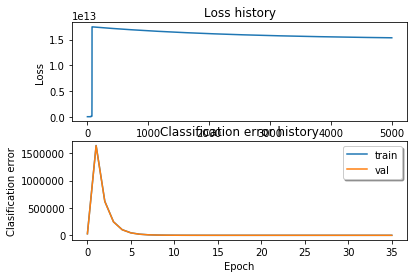

In [12]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

# Finetuning and Improving Your Network (Bonus)
There are many aspects and hyper-parameters you can play with. Do play with them and find the best setting here.